<a href="https://colab.research.google.com/github/Sherma-ThangamS/Zeotap_Assignment/blob/main/Sherma_SelvaKumar_Lookalike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd

# Replace with your actual file paths if they are different
customers_url = "https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE"
products_url = "https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0"
transactions_url = "https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF"


try:
  customers_df = pd.read_csv(customers_url)
  products_df = pd.read_csv(products_url)
  transactions_df = pd.read_csv(transactions_url)

  print("Customers DataFrame:")
  print(customers_df.head())

  print("\nProducts DataFrame:")
  print(products_df.head())

  print("\nTransactions DataFrame:")
  print(transactions_df.head())

except Exception as e:
  print(f"An error occurred: {e}")

Customers DataFrame:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products DataFrame:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions DataFrame:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# Merge the data to associate customers with products they purchased
customer_transactions = transactions_df.merge(products_df, on='ProductID')

# Create a customer-profile dataframe
customer_profiles = customers_df[['CustomerID', 'Region']]

# Extract features: Region, and product category frequencies
customer_transactions['Category'] = customer_transactions['Category'].str.split()
category_matrix = customer_transactions.explode('Category').groupby(['CustomerID', 'Category'])['Quantity'].sum().unstack(fill_value=0)
category_matrix = category_matrix.fillna(0)  # 1 means the customer bought this category, 0 means not.

In [26]:
# Compute similarity for top 20 customers
similarity_scores = defaultdict(list)
for i, customer_id in enumerate(customers_df['CustomerID'][:20]):
    customer_vector = category_matrix.loc[customer_id].values.reshape(1, -1)

    # Calculate cosine similarity for each customer
    similarities = cosine_similarity(customer_vector, category_matrix.values).flatten()

    # Sort by similarity score and pick the top 3
    top_3_similarities = np.argsort(similarities)[::-1][1:4]  # Exclude the customer itself
    top_3_customers = [(customers_df['CustomerID'][idx], similarities[idx]) for idx in top_3_similarities]

    similarity_scores[customer_id] = top_3_customers

In [27]:
# Prepare output for Lookalike.csv
lookalike_data = []
for customer_id, recommendations in similarity_scores.items():
    row = [customer_id]
    for rec in recommendations:
        row.append(rec[0])  # Customer ID of the lookalike
        row.append(rec[1])  # Similarity score
    lookalike_data.append(row)

lookalike_df = pd.DataFrame(lookalike_data, columns=["CustomerID", "Lookalike_1_ID", "Lookalike_1_Score", "Lookalike_2_ID", "Lookalike_2_Score", "Lookalike_3_ID", "Lookalike_3_Score"])

# Save to CSV
lookalike_df.to_csv("Lookalike.csv", index=False)

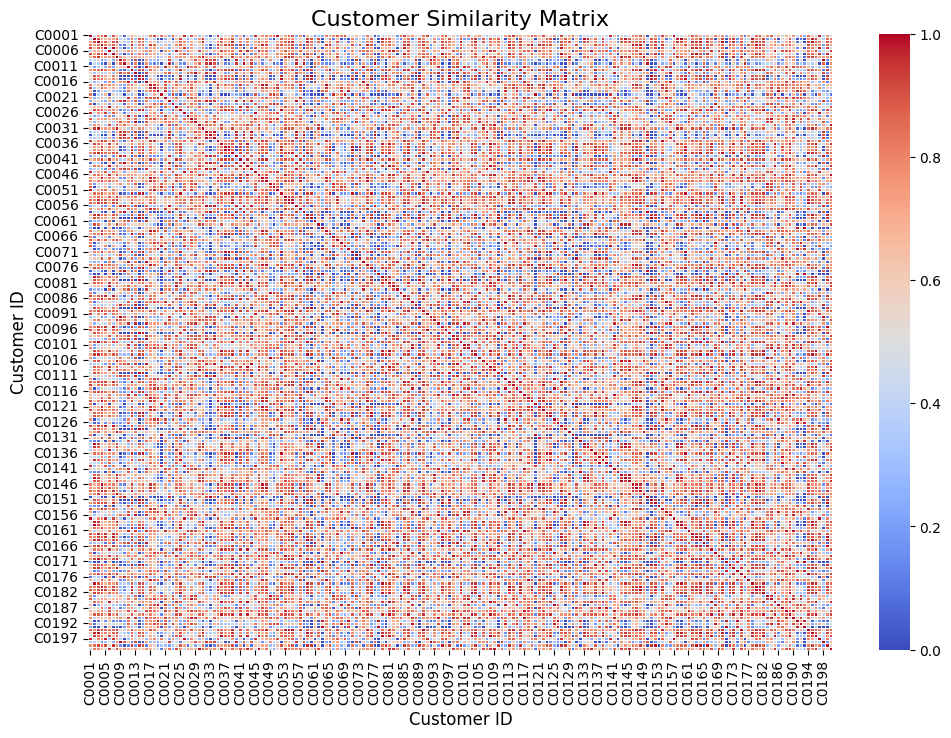

In [28]:
# Calculate cosine similarity for all customers based on their transaction patterns
similarity_matrix = cosine_similarity(category_matrix.values)

# Convert the numpy array to a DataFrame for better readability
similarity_df = pd.DataFrame(similarity_matrix, index=category_matrix.index, columns=category_matrix.index)

# Now, let's visualize the similarity matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_df, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title("Customer Similarity Matrix", fontsize=16)
plt.xlabel("Customer ID", fontsize=12)
plt.ylabel("Customer ID", fontsize=12)
plt.show()


In [29]:
top_3_evaluation = []

# Get the top 3 recommendations for the first 20 customers
for i in range(20):  # First 20 customers
    customer_id = category_matrix.index[i]

    # Get similarities for the current customer with all other customers
    similarities = similarity_df[customer_id].sort_values(ascending=False)

    # Get top 3 similar customers (exclude the customer itself)
    top_3_similar_customers = similarities.iloc[1:4]  # Skipping self

    # Append results: CustomerID, top 3 lookalikes and their similarity scores
    top_3_evaluation.append({
        'CustomerID': customer_id,
        'Lookalike_1_ID': top_3_similar_customers.index[0],
        'Lookalike_1_Score': top_3_similar_customers.iloc[0],
        'Lookalike_2_ID': top_3_similar_customers.index[1],
        'Lookalike_2_Score': top_3_similar_customers.iloc[1],
        'Lookalike_3_ID': top_3_similar_customers.index[2],
        'Lookalike_3_Score': top_3_similar_customers.iloc[2]
    })

# Convert the evaluation to a DataFrame
top_3_df = pd.DataFrame(top_3_evaluation)

# Display the top 3 recommendations for the first 20 customers
top_3_df

,CustomerID,Lookalike_1_ID,Lookalike_1_Score,Lookalike_2_ID,Lookalike_2_Score,Lookalike_3_ID,Lookalike_3_Score
0,C0001,C0157,0.992159,C0051,0.978064,C0197,0.969003
1,C0002,C0159,0.999229,C0133,0.995774,C0178,0.990867
2,C0003,C0170,0.995227,C0100,0.990536,C0195,0.980581
3,C0004,C0146,0.998645,C0119,0.988483,C0148,0.976223
4,C0005,C0007,0.990148,C0127,0.983612,C0197,0.980196
5,C0006,C0024,0.988837,C0135,0.988064,C0082,0.977363
6,C0007,C0127,0.993399,C0163,0.990148,C0005,0.990148
7,C0008,C0149,0.985794,C0031,0.980581,C0106,0.971489
8,C0009,C0009,1.000000,C0092,0.998274,C0040,0.976187
9,C0010,C0010,1.000000,C0077,0.999480,C0150,0.980581


In [30]:
# Calculate mean similarity scores for the top 3 lookalike recommendations
mean_similarity_score = top_3_df[['Lookalike_1_Score', 'Lookalike_2_Score', 'Lookalike_3_Score']].mean(axis=1)

# Add the mean similarity score to the evaluation dataframe
top_3_df['Mean_Similarity_Score'] = mean_similarity_score

# Display the updated dataframe
top_3_df[['CustomerID', 'Lookalike_1_Score', 'Lookalike_2_Score', 'Lookalike_3_Score', 'Mean_Similarity_Score']]


,CustomerID,Lookalike_1_Score,Lookalike_2_Score,Lookalike_3_Score,Mean_Similarity_Score
0,C0001,0.992159,0.978064,0.969003,0.979742
1,C0002,0.999229,0.995774,0.990867,0.995290
2,C0003,0.995227,0.990536,0.980581,0.988781
3,C0004,0.998645,0.988483,0.976223,0.987784
4,C0005,0.990148,0.983612,0.980196,0.984652
5,C0006,0.988837,0.988064,0.977363,0.984755
6,C0007,0.993399,0.990148,0.990148,0.991231
7,C0008,0.985794,0.980581,0.971489,0.979288
8,C0009,1.000000,0.998274,0.976187,0.991487
9,C0010,1.000000,0.999480,0.980581,0.993354


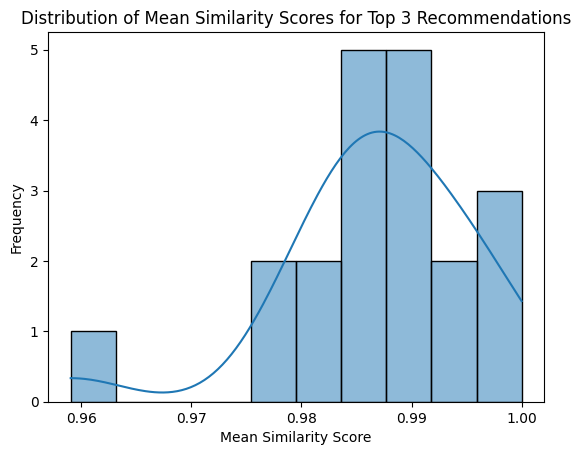

In [31]:
# Plot histogram of the top 3 similarity scores
sns.histplot(top_3_df['Mean_Similarity_Score'], kde=True, bins=10)
plt.title('Distribution of Mean Similarity Scores for Top 3 Recommendations')
plt.xlabel('Mean Similarity Score')
plt.ylabel('Frequency')
plt.show()
